*UID*: 120061660, 117987683, 119646878



# **CMSC426 Project 1: Color Segmentation using GMM**

# Introduction

Have you ever played with these adorable Nao robots? Click [here](http://www.youtube.com/watch?feature=player_embedded&v=Gy_wbhQxd_0) to watch a cool demo.

Nao robots are star players in RoboCup, an annual autonomous robot soccer competitions. Would you like to help us in Nao’s soccer training? We need to train Nao to detect a soccer ball and estimate the depth of the ball to know how far to kick.

Nao’s training has two phases:

- Color Segmentation using Gaussian Mixture Model (GMM)
- Ball Distance Estimation


<a name='problem'></a>
# What you need to do

To make logistics easier, we have collected camera data from Nao robot on behalf of you and saved the data in the form of color images. Click [here](https://drive.google.com/file/d/1k1dydl1Yho08isNg-_542fajXujybujH/view?usp=sharing) to download, or **run the following code block to download the training image folder to the file directory of the notebook**. The image names represent the depth of the ball from Nao robot in centimeters. -We will release the test dataset 48 hours before the deadline. **Test images are available [here](https://drive.google.com/file/d/1_qC1OnK58kYfBKZ9FUYnSmBLdfTpRmSr/view?usp=sharing) to download.**

In [1]:
# # Download training images from Google Drive
# import gdown
# gdown.download_folder(id="18Mx2Xc9UNFZYajYu9vfmRFlFCcna5I0J", quiet=True, use_cookies=False)

In [2]:
# # Download testing images from Google Drive
# gdown.download_folder(id="1Yl4_5O_ZEkz_KJVs0_vS5TrZUqMYkwr4", quiet=True, use_cookies=False)

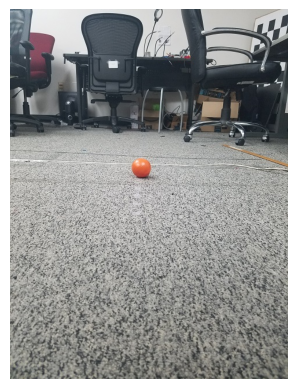

In [3]:
# Check whether the training images were successfully imported
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

train_image = mpimg.imread('./train_images/106.jpg')
plt.imshow(train_image)
plt.axis("off")
plt.show()

## Problem Statement

1. Write Python code to cluster the orange ball using [Single Gaussian](https://cmsc426.github.io/colorseg/#gaussian) [30 points]

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Ellipse
from scipy.optimize import curve_fit
import plotly.graph_objs as go
import numpy as np
from scipy.stats import chi2
from sklearn.cluster import KMeans

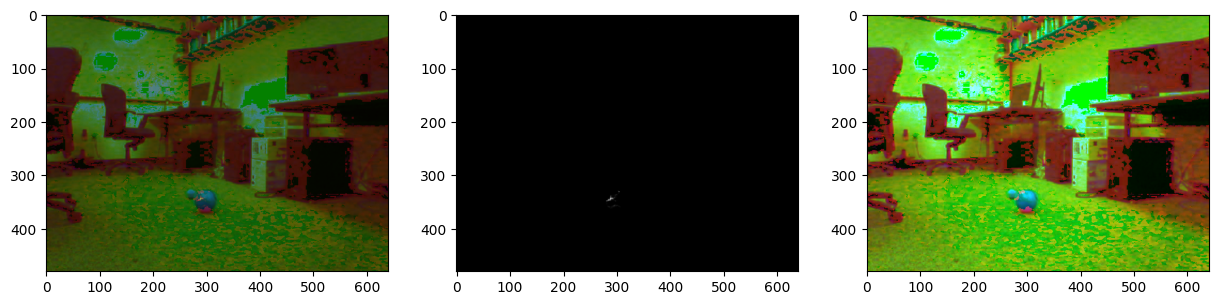

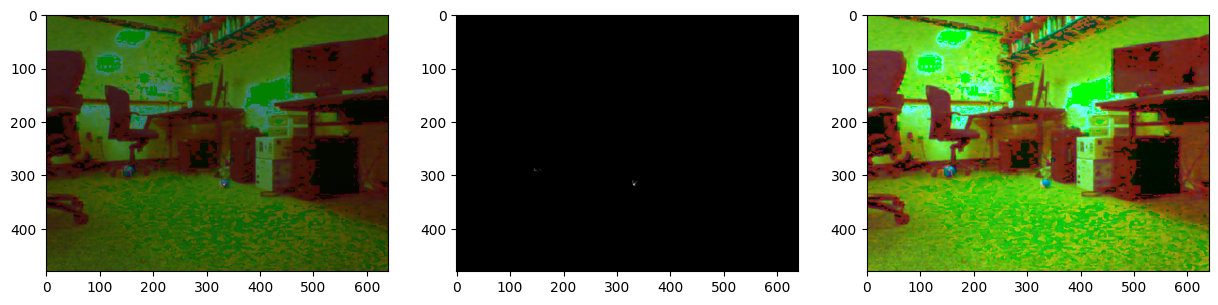

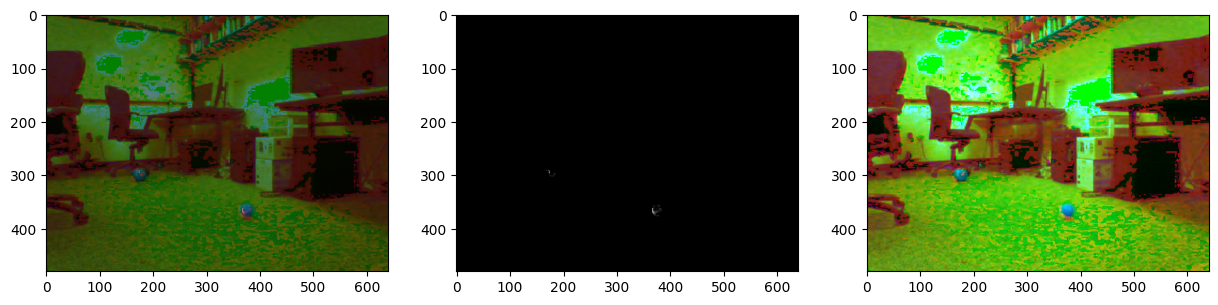

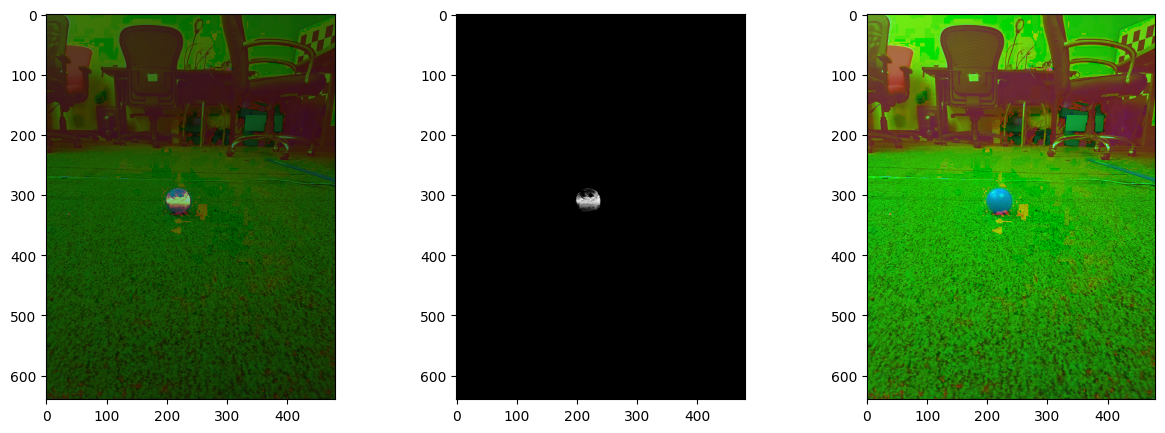

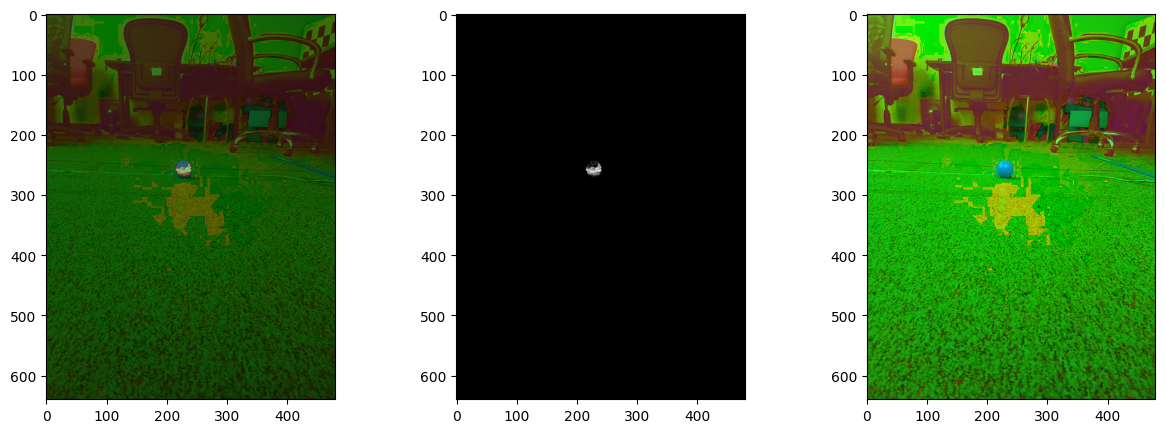

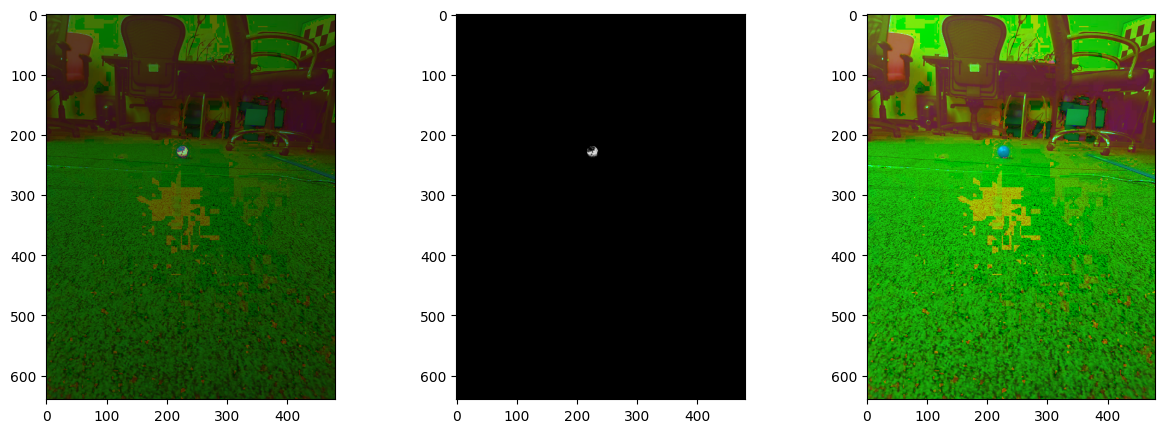

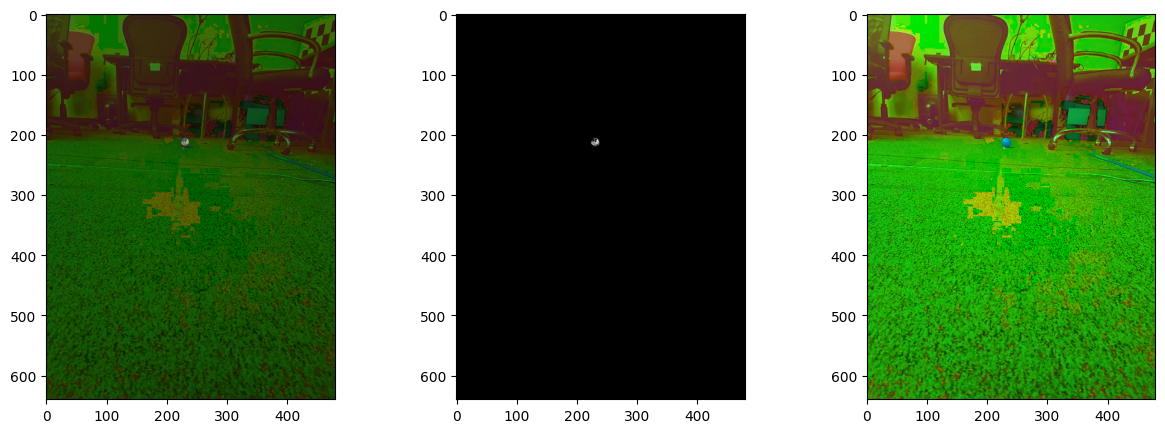

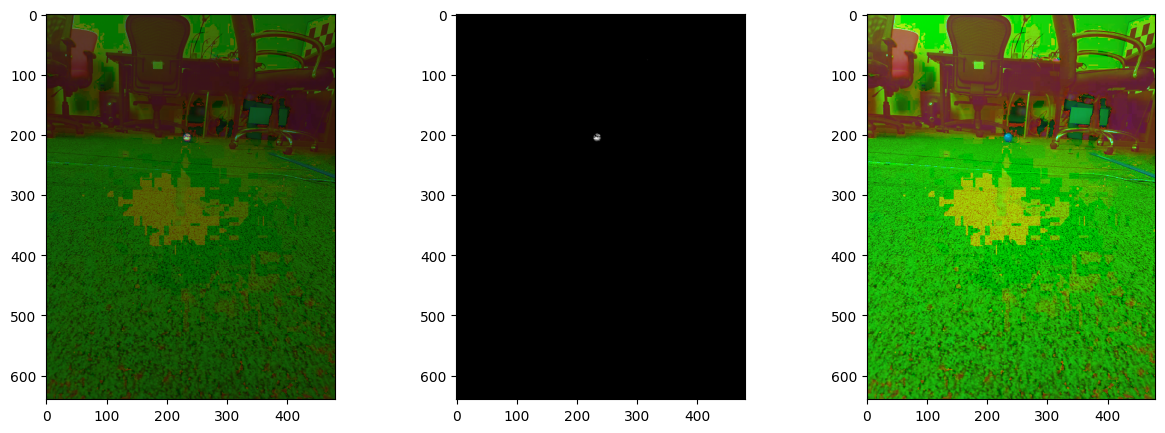

In [5]:
train = []

for image in os.listdir('./train_images'):
    img = cv2.imread('./train_images/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    train.append(img)

train = np.array(train)

orange = []

for img in train:
    lower = np.array([0, 100, 120]) 
    upper = np.array([30, 240, 250]) 
    mask = cv2.inRange(img, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)
    orange.append(result)

# for i in range(len(orange)):
#     plt.figure(figsize=(15,5))
#     plt.subplot(131)
#     plt.imshow(train[i])
#     plt.subplot(132)
#     plt.imshow(orange[i])
#     plt.show()

orange = np.array(orange)
# print(orange.shape)
flattened = orange.reshape(-1, 3) #23 images of 480x640 pixels = 737280 pixels and then 3 channels HSV
flattened = flattened[(flattened[:, 0] != 0) & (flattened[:, 1] != 0) & (flattened[:, 2] != 0)] #remove black pixels because they are not orange
# print(flattened.shape)

mean = np.mean(flattened, axis=0)
cov = np.cov(flattened.T)

def pdf(x, mean, cov):
    x = x - mean
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm = 1.0 / (((2 * np.pi)**(3/2)) * np.sqrt(det))
    exp = np.exp(-0.5 * np.dot(x.T, np.dot(inv, x)))
    pdf = norm * exp
    return pdf

def gaussian_pdf(x, mean, cov): #for 2d
    d = x.shape[1]
    x_m = x - mean
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    
    log_norm_const = -0.5 * (d * np.log(2 * np.pi) + np.log(det_cov))
    log_exp_term = -0.5 * np.sum((x_m @ inv_cov) * x_m, axis=1)
    
    return np.exp(log_norm_const + log_exp_term)

threshold = 1e-5
prior = 0.25

def detector(image, mean, cov, threshold, prior):
    original_shape = image.shape
    image = image.reshape(-1, 3)
    pdf_values = gaussian_pdf(image, mean, cov)
    probability = (pdf_values * prior)
    #probability[probability < threshold] = 0
    return probability.reshape(original_shape[:2])

for image in os.listdir('./test_images'):
    img_arr = []
    img = cv2.imread('./test_images/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    detected = detector(img, mean, cov, threshold, prior)
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(img)
    plt.imshow(detected, cmap='hot', alpha=0.5)
    plt.subplot(132)
    plt.imshow(detected, cmap='gray')
    plt.subplot(133)
    plt.imshow(img)
    plt.show()
    img_arr.append(detected)

2. Write Python code to cluster the orange ball using [Gaussian Mixture Model](https://cmsc426.github.io/colorseg/#gmm) [40 points] and estimate the [distance](https://cmsc426.github.io/colorseg/#distest) to the ball [20 points]. Also, plot all the GMM ellipsoids [10 points].


You are NOT allowed to use any built-in Python package(s) like *sklearn.mixture.GaussianMixture* for GMM. To help you with code implementation, we have given the pseudocode :-)

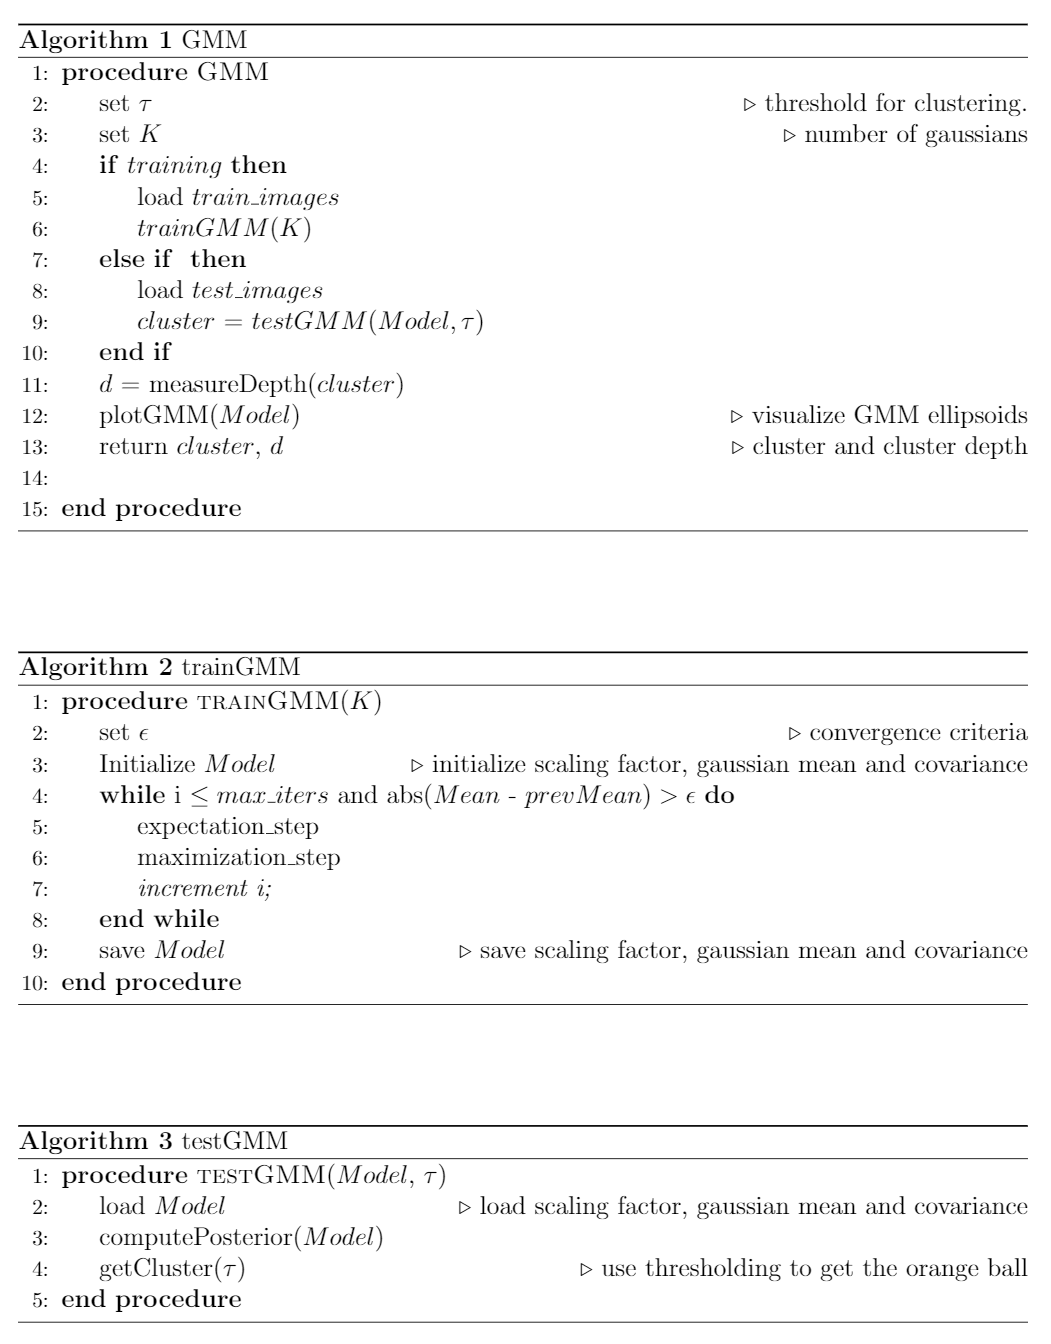

In [6]:
def gaussian_pdf(x, mean, cov): #for 2d
    d = x.shape[1]
    x_m = x - mean
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    
    log_norm_const = -0.5 * (d * np.log(2 * np.pi) + np.log(det_cov))
    log_exp_term = -0.5 * np.sum((x_m @ inv_cov) * x_m, axis=1)
    
    return np.exp(log_norm_const + log_exp_term)

def pdf(x, mean, cov): #for 1d
    x = x - mean
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm = 1.0 / ((2 * np.pi)**(3/2) * np.sqrt(det))
    exp = np.exp(-0.5 * np.dot(x.T, np.dot(inv, x)))
    pdf = norm * exp
    return pdf

def expectation_step(data, weights, means, covariances):
    N = data.shape[0]
    K = len(weights)
    
    resp = np.zeros((N, K))
    
    for i in range(K):
        resp[:, i] = weights[i] * gaussian_pdf(data, means[i], covariances[i])
    
    resp_sum = resp.sum(axis=1, keepdims=True)
    resp = np.divide(resp, resp_sum, where=resp_sum!=0)
    
    return resp

def maximization_step(data, responsibilities):
    N, K = responsibilities.shape
    d = data.shape[1]
    
    resp = responsibilities.sum(axis=0)
    means = (responsibilities.T @ data) / np.maximum(resp[:, np.newaxis], 1e-8)
    covariances = np.zeros((K, d, d))

    for k in range(K):
        diff = data - means[k]
        covariances[k] = (responsibilities[:, k, np.newaxis] * diff).T @ diff / np.maximum(resp[k], 1e-8) #cal covariance matrix
        covariances[k] += np.eye(d) * 1e-6  # numerical stability and to avoid those warning messages
    
    weights = resp / N
    
    return means, covariances, weights

def compute_likelihood_vectorized(pixels, means, covariances):
    K = len(means)
    N = pixels.shape[0]
    likelihoods = np.zeros((N, K))
    
    for i in range(K):
        likelihoods[:, i] = gaussian_pdf(pixels, mean=means[i], cov=covariances[i])
    
    return likelihoods


def compute_posterior_vectorized(pixels, scalars, means, covariances):
    likelihoods = compute_likelihood_vectorized(pixels, means, covariances)
    weighted_likelihoods = scalars * likelihoods
    sum_weighted_likelihoods = np.sum(weighted_likelihoods, axis=1, keepdims=True)
    return weighted_likelihoods / sum_weighted_likelihoods

In [16]:
def trainGMM(K, data, max_iters=1000, e=1e-12):

    N, d = data.shape
    
    np.random.seed(42)
    kmeans = KMeans(n_clusters=K, random_state=42).fit(data)
    means = kmeans.cluster_centers_
    covariances = np.array([np.cov(data.T) + np.eye(d) * 1e-3 for _ in range(K)]) #numerical stability
    weights = np.ones(K) / K
    
    prev_means = np.zeros_like(means)
    i = 0 

    while i < max_iters and np.linalg.norm(means - prev_means) > e:
        prev_means = means.copy()

        responsibilities = expectation_step(data, weights, means, covariances)
        means, covariances, weights = maximization_step(data, responsibilities)

        i += 1
    
    return weights, means, covariances


def testGMM(Model_parameters, threshold, prior):
    scalars, means, covariances = Model_parameters

    test_image_folder = './test_images'
    result_folder = './result_images'
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)

    images = [f for f in os.listdir(test_image_folder) if f.endswith('.jpg')]

    cluster_parameters = []

    for image_name in images:
        img = cv2.imread(os.path.join(test_image_folder, image_name))
        img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        height, width, _ = img_hls.shape
        pixels = img_hls.reshape((-1, 3))


        posteriors = compute_posterior_vectorized(pixels, scalars, means, covariances)
        posteriors = 1 - posteriors 
        ball_component = np.argmin(np.sum(posteriors, axis=0)) 
        segmentation_map = posteriors[:, ball_component].reshape((height, width)) 
        binary_map = (segmentation_map > threshold).astype(np.uint8)
        binary_map = (binary_map * 255).astype(np.uint8)
        segmentation_map = 1 - segmentation_map
        contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(largest_contour)
            cluster_parameters.append((x, y, radius))

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        ax2.imshow(binary_map, cmap='hot')
        ax2.set_title('Binary Map')
        ax2.axis('off')

        ax3.imshow(segmentation_map, cmap='gray')
        ax3.set_title('Segmentation Map')
        ax3.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(result_folder, f'segmented_{image_name}'))
        plt.show()
        plt.close()

    print("Segmentation complete. Results saved in the result folder.")
    return cluster_parameters, binary_map

def measureDepth(cluster_parameters):
    radii = np.array([params[2] for params in cluster_parameters])
    print("Radii:", radii)

    # Sort radii in descending order (larger radius = closer object)
    sorted_indices = np.argsort(radii)[::-1]
    sorted_radii = radii[sorted_indices]

    # Create relative distances (1 for closest, increasing for farther)
    relative_distances = np.arange(1, len(radii) + 1)

    # Define the inverse model function
    def inverse_model(x, a, b):
        return a / (x + b)

    # Fit the model to our data
    popt, pcov = curve_fit(inverse_model, relative_distances, sorted_radii, p0=[np.max(radii), 1], bounds=([0, 0], [np.inf, np.inf]))

    # Extract the fitted parameters
    a, b = popt
    print("Fitted parameters: a =", a, "b =", b)

    # Function to estimate relative distance based on radius
    def estimate_relative_distance(radius):
        return (a / radius) - b

    # Estimate relative distances for all balls
    estimated_distances = np.array([estimate_relative_distance(radius) for radius in radii])
    normalized_distances = 1 + (len(radii) - 1) * (estimated_distances - np.min(estimated_distances)) / (np.max(estimated_distances) - np.min(estimated_distances))
    final_distances = normalized_distances[np.argsort(sorted_indices)]

    print("Estimated relative distances:", final_distances)
    return final_distances.tolist()

def plotGMM(Model_parameters, flattened):

    scalars, means, covariances = Model_parameters
    K = len(scalars)

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=flattened[:, 0], y=flattened[:, 1], z=flattened[:, 2],
        mode='markers',
        marker=dict(size=1, color=flattened[:, 0], colorscale='Viridis'),
        showlegend=False
    ))
    def sphere_points(n):
        theta = np.random.uniform(0, 2*np.pi, n)
        phi = np.arccos(np.random.uniform(-1, 1, n))
        x = np.sin(phi) * np.cos(theta)
        y = np.sin(phi) * np.sin(theta)
        z = np.cos(phi)
        return np.column_stack((x, y, z))
    
    for i in range(K):
        mean = means[i]
        covariance = covariances[i]
        
        points = sphere_points(500)

        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        scaling_matrix = np.sqrt(eigenvalues) * np.sqrt(chi2.ppf(0.95, 3))
        points = np.dot(points * scaling_matrix, eigenvectors.T) + mean

        fig.add_trace(go.Mesh3d(
            x=points[:, 0], y=points[:, 1], z=points[:, 2],
            alphahull=0,
            opacity=0.3,
            color=f'rgb({np.random.randint(0, 256)}, {np.random.randint(0, 256)}, {np.random.randint(0, 256)})',
            name=f'Gaussian {i + 1}'
        ))

    fig.update_layout(
        title='GMM',
        scene=dict(xaxis_title='hue', yaxis_title='lightness', zaxis_title='saturation')
    )

    fig.show()

In [8]:
threshold = 0.000065
prior = 0.00025
K = 3 

train = []

for image in os.listdir('./train_images'):
    img = cv2.imread('./train_images/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    train.append(img)

train = np.array(train)

orange = []

for img in train:
    lower = np.array([0, 100, 120]) 
    upper = np.array([30, 240, 250])
    mask = cv2.inRange(img, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)
    orange.append(result)

orange = np.array(orange)

flattened = orange.reshape(-1, 3)
print(flattened.shape)
flattened = flattened[(flattened[:, 0] > 5) & (flattened[:, 1] > 5) & (flattened[:, 2] > 5)]
print(flattened.shape)

Model_parameters = trainGMM(K, flattened)

print("Final GMM parameters:")
print("Weights:", Model_parameters[0])
print("Means:", Model_parameters[1])
print("Covariances:", Model_parameters[2])

plotGMM(Model_parameters, flattened)

(7065600, 3)
(7575, 3)
Final GMM parameters:
Weights: [0.14540747 0.36804394 0.48654859]
Means: [[  9.08631472 165.98758772 144.37392698]
 [  9.46824821 175.32696651 216.80280146]
 [  7.2243035  142.89897002 172.72548639]]
Covariances: [[[ 6.21167596e+00  2.43056411e+01 -3.29690408e+00]
  [ 2.43056411e+01  6.05990279e+02  1.17538375e+02]
  [-3.29690408e+00  1.17538375e+02  3.37543404e+02]]

 [[ 1.92828789e+00 -4.78861375e-01  7.81510995e+00]
  [-4.78861375e-01  2.04337120e+02  1.03586493e+02]
  [ 7.81510995e+00  1.03586493e+02  4.01713761e+02]]

 [[ 1.06294443e+00  6.50220531e+00  1.17647618e+01]
  [ 6.50220531e+00  9.14423900e+01  1.43271346e+02]
  [ 1.17647618e+01  1.43271346e+02  2.80696920e+02]]]


C:\Users\aryan\AppData\Local\Temp\ipykernel_31636\740190426.py:67: RuntimeWarning:

invalid value encountered in divide



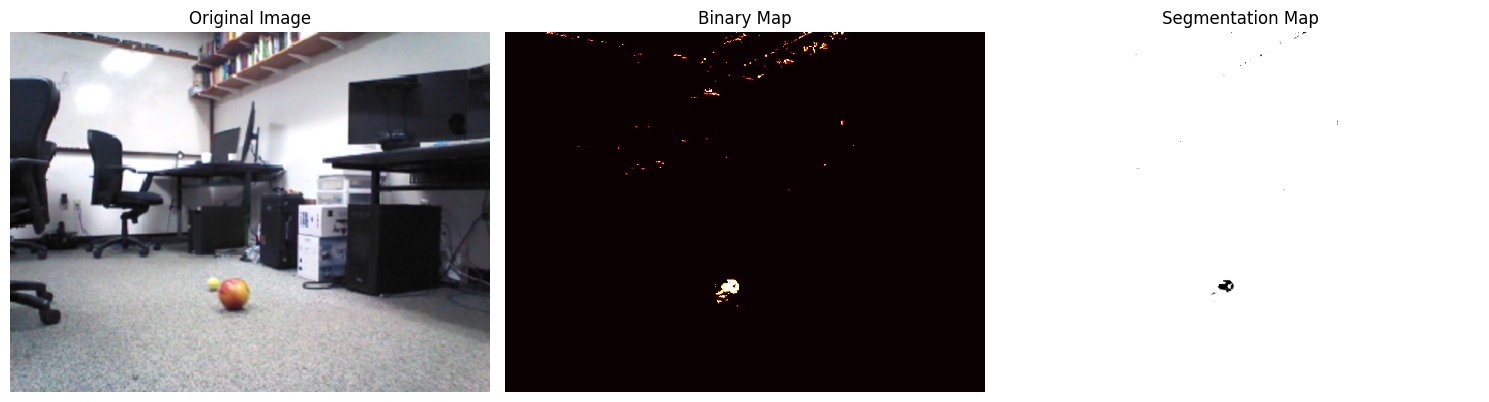

C:\Users\aryan\AppData\Local\Temp\ipykernel_31636\740190426.py:67: RuntimeWarning:

invalid value encountered in divide



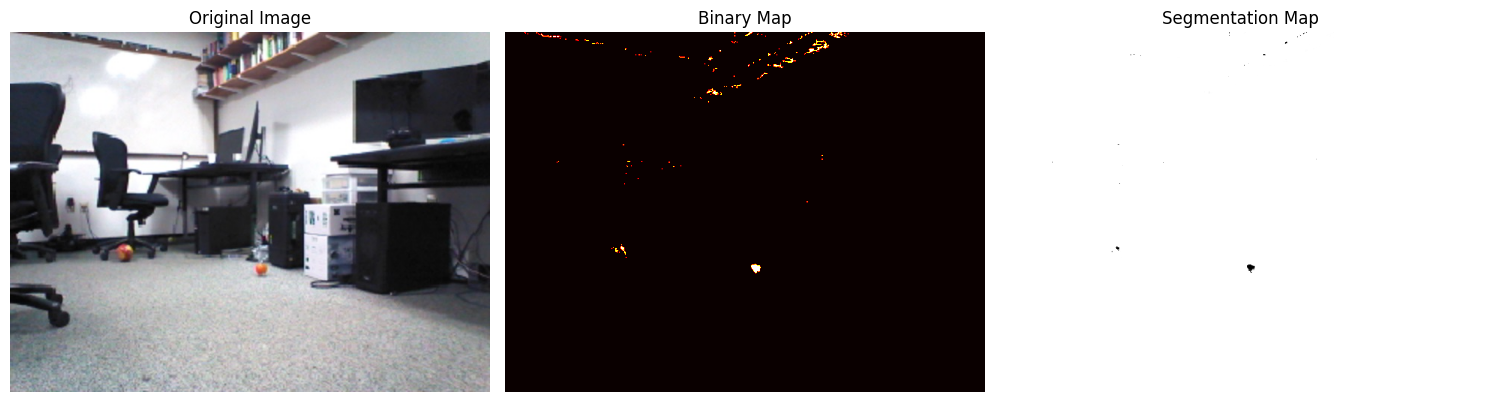

C:\Users\aryan\AppData\Local\Temp\ipykernel_31636\740190426.py:67: RuntimeWarning:

invalid value encountered in divide



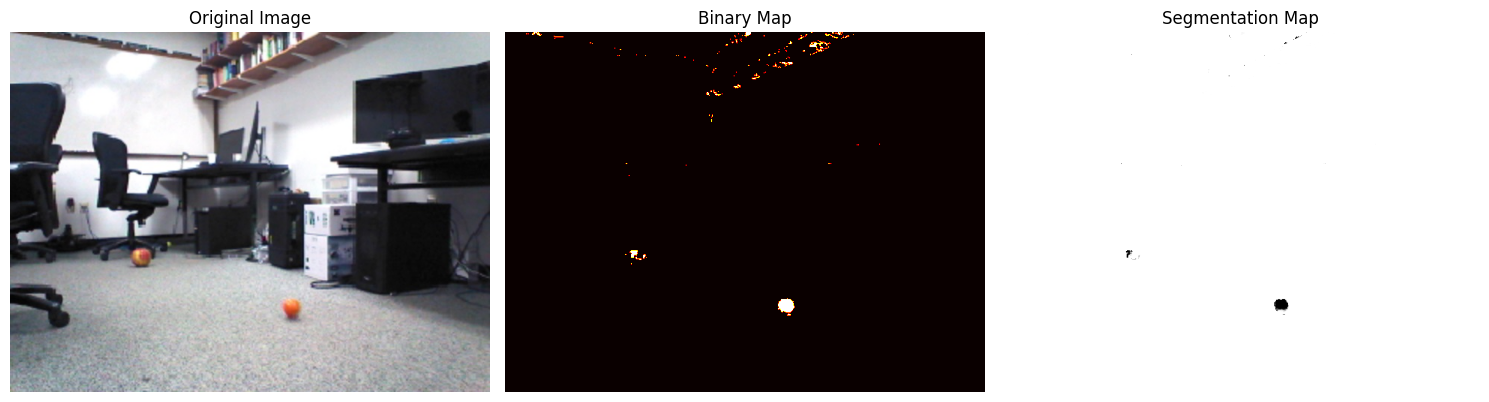

C:\Users\aryan\AppData\Local\Temp\ipykernel_31636\740190426.py:67: RuntimeWarning:

invalid value encountered in divide



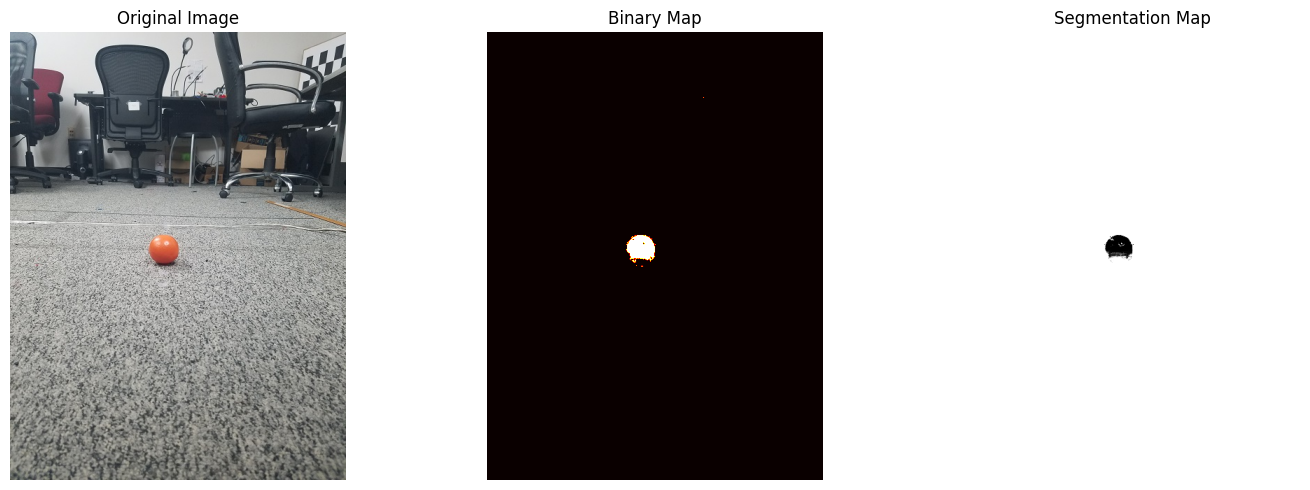

C:\Users\aryan\AppData\Local\Temp\ipykernel_31636\740190426.py:67: RuntimeWarning:

invalid value encountered in divide



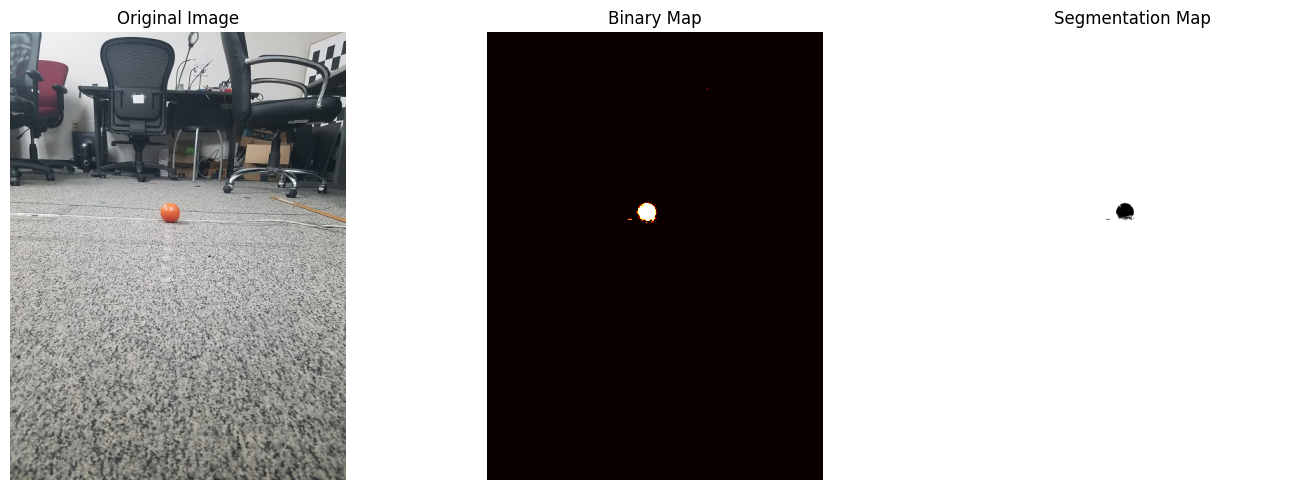

C:\Users\aryan\AppData\Local\Temp\ipykernel_31636\740190426.py:67: RuntimeWarning:

invalid value encountered in divide



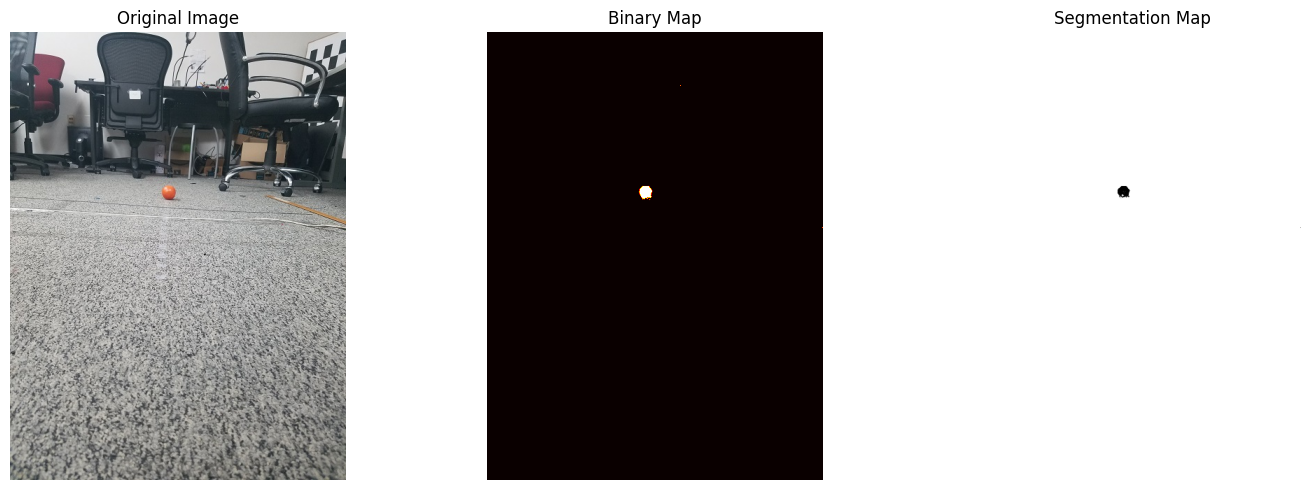

C:\Users\aryan\AppData\Local\Temp\ipykernel_31636\740190426.py:67: RuntimeWarning:

invalid value encountered in divide



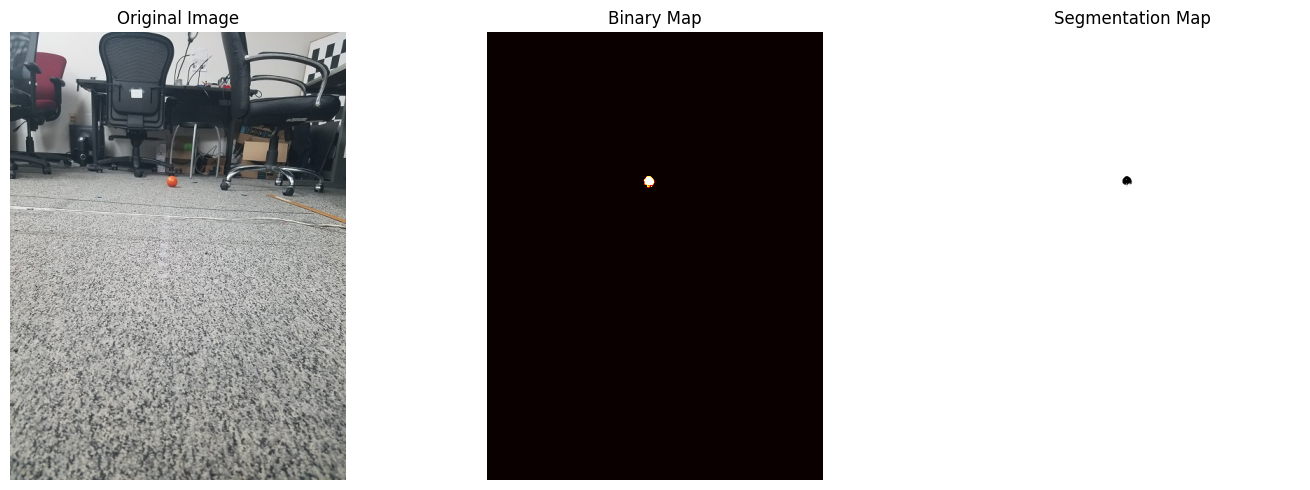

C:\Users\aryan\AppData\Local\Temp\ipykernel_31636\740190426.py:67: RuntimeWarning:

invalid value encountered in divide



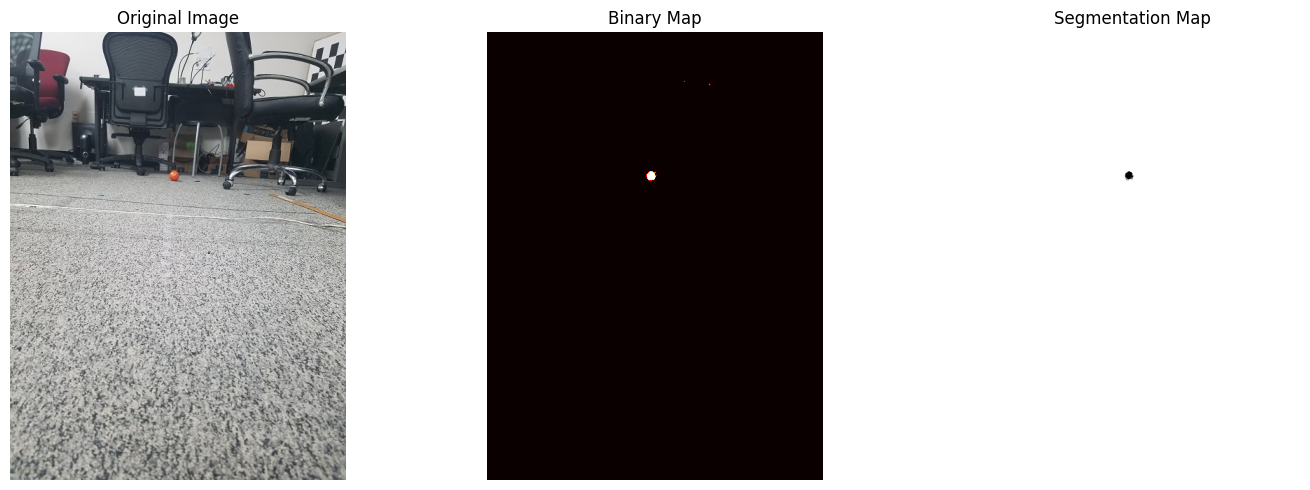

Segmentation complete. Results saved in the result folder.
[(296.0, 342.5, 16.347881317138672), (333.59259033203125, 314.4444580078125, 6.568308353424072), (374.1470642089844, 364.29412841796875, 11.185275077819824), (219.5, 310.0, 21.914705276489258), (228.6290283203125, 258.1129150390625, 14.67140007019043), (226.5, 229.0, 10.062405586242676), (230.5, 213.36666870117188, 7.779419422149658), (234.87142944335938, 204.9857177734375, 7.152695178985596)]
Radii: [16.34788132  6.56830835 11.18527508 21.91470528 14.67140007 10.06240559
  7.77941942  7.15269518]
Fitted parameters: a = 68.90384412619824 b = 2.1247543205397648
Estimated relative distances: [8.         7.18330867 1.         2.02021372 3.87392305 2.47914371
 4.52895363 6.44380493]


In [17]:
cluster_parameters, bin_2 = testGMM(Model_parameters,threshold, prior)
print(cluster_parameters)
distance = measureDepth(cluster_parameters)

# Video Lecture
Click [here](https://www.youtube.com/watch?v=D5AcaFMY_BI) for a video lecture to help you better understand the project.

## Report
For each section of the project, explain briefly what you did, and describe any interesting problems you encountered and/or solutions you implemented. You must include the following details in your writeup:

- Your choice of color space, initialization method and number of gaussians in the GMM
- Explain why GMM is better than single gaussian
- Present your distance estimate and cluster segmentation results for each test image
- Explain strengths and limitations of your algorithm. Also, explain why the algorithm failed on some test images

As usual, your report must be full English sentences, not commented code. There is a word limit of 1500 words and no minimum length requirement.

## ***add your report here***


# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj1.pdf**. For example, xyz123_proj1.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to ELMS(Canvas).**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2023 website.